<a href="https://colab.research.google.com/github/JaschaNi/TechLabs/blob/main/Kopie_von_Feb18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

In [ ]:
# need to be done once
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# need to be done once
# on Kaggle in the Profil go to Edit Profil, then download API Token and upload here, will be saved in Drive then
from google.colab import files
files.upload()

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Dataset to big
#!kaggle competitions download -c siim-isic-melanoma-classification

In [ ]:
# found a new dataset which is already resized to 300x300 and 640x640
!kaggle datasets download bitthal/resize-jpg-siimisic-melanoma-classification
!unzip /content/resize-jpg-siimisic-melanoma-classification.zip

In [ ]:
import numpy as np
import pandas as pd

# load and display an image with Matplotlib
from matplotlib import image
#from matplotlib import pyplot

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import EfficientNetB0

In [ ]:
img_path = '/content/300x300/train/'

IMG_SIZE = 224

#NUM_CLASSES = 2

uint8
(300, 300, 3)


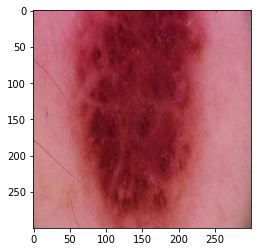

In [ ]:
# load image as pixel array
image_test = image.imread(img_path + 'ISIC_9999806.jpg')
# summarize shape of the pixel array
print(image_test.dtype)
print(image_test.shape)
# display the array of pixels as an image
plt.imshow(image_test)
plt.show()

In [ ]:
train_csv = pd.read_csv('/content/drive/MyDrive/TechLabs/ISIC_2020_Training_GroundTruth.csv')
#train_csv = pd.read_csv('train.csv')

In [ ]:
print(train_csv.head())

     image_name  patient_id     sex  ...  diagnosis benign_malignant target
0  ISIC_2637011  IP_7279968    male  ...    unknown           benign      0
1  ISIC_0015719  IP_3075186  female  ...    unknown           benign      0
2  ISIC_0052212  IP_2842074  female  ...      nevus           benign      0
3  ISIC_0068279  IP_6890425  female  ...    unknown           benign      0
4  ISIC_0074268  IP_8723313  female  ...    unknown           benign      0

[5 rows x 8 columns]


### test

In [ ]:
# add path to image names for loading

train_data = []
for img in train_csv['image_name']:
  train_data.append(img_path + img + '.jpg')
len(train_data), train_data[0]

(33126, '/content/300x300/train/ISIC_2637011.jpg')

In [ ]:
train_label = train_csv['target']
len(train_label), train_label[10]

(33126, 0)

In [ ]:
# make new dataframe, only with images names and path

train_df = pd.DataFrame(train_data)
train_df.columns = ['image']
train_df['target'] = train_label

In [ ]:
# split dataset into train set and validation set

X_train, X_val, y_train, y_val = train_test_split(train_df['image'], train_df['target'], test_size=0.2)

train_data = pd.DataFrame({'image': X_train, 'target': y_train})
val_data = pd.DataFrame({'image': X_val, 'target': y_val})

In [ ]:
# use tensorflow ImageDataGenerator to load images for input 
# from https://keras.io/api/preprocessing/image/#flow_from_dataframe-method

# train generator with augmentation (flips) and rescale, so that values are between 0 & 1
train_data_gen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)

train_generator = train_data_gen.flow_from_dataframe(
    train_data,
    x_col='image',
    y_col='target',
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=True
)

# validation generator with rescale, so that values are between 0 & 1
validation_data_gen = ImageDataGenerator()

validation_generator = validation_data_gen.flow_from_dataframe(
    val_data,
    x_col='image',
    y_col='target',
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=False
)


Found 26500 validated image filenames.
Found 6626 validated image filenames.


next steps also from [keras.io](https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/) ->
Image classification via fine-tuning with EfficientNet

modified to binary classification with only two classes

In [ ]:
effnet = EfficientNetB0(weights='imagenet', drop_connect_rate=0.4, include_top=False)

16711680/16705208 [==============================] - 0s 0us/step


In [ ]:
from tensorflow.keras import layers

def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.3
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)

    #changed softmax to sigmoid because of binary classification
    outputs = layers.Dense(1, activation="sigmoid", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
    )
    return model

In [ ]:
model = build_model(1)

In [ ]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

Epoch 1/5
829/829 [==============================] - 114s 125ms/step - loss: 0.5889 - accuracy: 0.7161 - val_loss: 0.1299 - val_accuracy: 0.9801
Epoch 2/5
829/829 [==============================] - 101s 122ms/step - loss: 0.1401 - accuracy: 0.9742 - val_loss: 0.0866 - val_accuracy: 0.9825
Epoch 3/5
829/829 [==============================] - 101s 122ms/step - loss: 0.0966 - accuracy: 0.9803 - val_loss: 0.0800 - val_accuracy: 0.9823
Epoch 4/5
829/829 [==============================] - 101s 121ms/step - loss: 0.0918 - accuracy: 0.9791 - val_loss: 0.0790 - val_accuracy: 0.9828
Epoch 5/5
829/829 [==============================] - 100s 121ms/step - loss: 0.0952 - accuracy: 0.9794 - val_loss: 0.0763 - val_accuracy: 0.9825


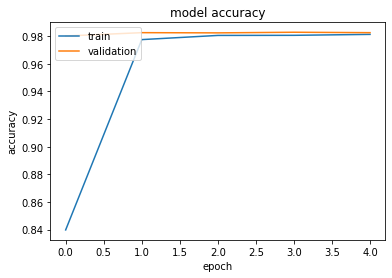

In [ ]:
EPOCHS = 5


hist = model.fit(
    x=train_generator, epochs=EPOCHS,
    verbose=1,
    validation_data=validation_generator)
plot_hist(hist)

next steps: 

unfreeze model and retrain


In [ ]:
def unfreeze_model(model):
    # We unfreeze the top 70 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-70:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(
        optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
    )


unfreeze_model(model)

In [ ]:
model.summary()

Epoch 1/2
829/829 [==============================] - 131s 151ms/step - loss: 0.0794 - accuracy: 0.9810 - val_loss: 0.0708 - val_accuracy: 0.9829
Epoch 2/2
829/829 [==============================] - 124s 150ms/step - loss: 0.0756 - accuracy: 0.9813 - val_loss: 0.0713 - val_accuracy: 0.9826


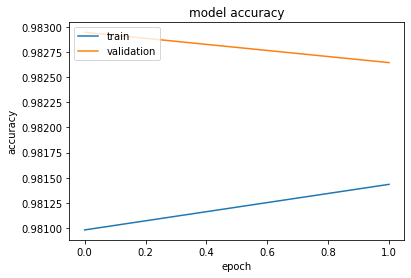

In [ ]:
EPOCHS = 2


hist = model.fit(
    x=train_generator, epochs=EPOCHS,
    verbose=1,
    validation_data=validation_generator)
plot_hist(hist)